# ЛАБОРАТОРИЯ

# Практическая работа

Огромное спасибо [Василию Гаршину](https://xle.2035.university/Archipelago20.35/author/6724) 


[Ссылка на материалы лаборатории](https://github.com/vgarshin/arkh_lab) 

## Подготовка к экспериментам

In [1]:
import os
import json
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed, GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
pd.set_option('display.max_columns', None)
print('tensorflow version:', tf.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)

tensorflow version: 2.3.1
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
MODEL_PATH = './models'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

def set_all_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_all_seeds(2035)

### Визуальный анализ данных

message_class: 1 | sample: [80020]
message_text: 1 | sample: [nan]
message_version: 1 | sample: [2]
message_number: 92 | sample: [212 213 214]
daylightsavingtime: 1 | sample: [2]
day: 92 | sample: [20180301 20180302 20180303]
timestamp: 22 | sample: [20180402094127 20180402094128 20180402094129]
name: 1 | sample: ['Umbrella Corp']
inn: 1 | sample: [7766553322]
area_timezone: 1 | sample: [1]
area_text: 1 | sample: [nan]
measuringpoint_code: 10 | sample: [9987268111202774 9987268111202786 9987268111202793]
measuringpoint_text: 1 | sample: [nan]
measuringpoint_name: 10 | sample: [11202774 11202786 11202793]
measuringpoint_serial: 10 | sample: [11202774 11202786 11202793]
measuringchannel_code: 1 | sample: [1]
measuringchannel_text: 1 | sample: [nan]
measuringchannel_desc: 1 | sample: ['акт. прием']
period_start: 48 | sample: [  0  30 100]
period_text: 1 | sample: [nan]
period_end: 48 | sample: [ 30 100 130]
value_status: 1 | sample: [0]
value_text: 1651 | sample: [87.8 87.4 88.4]
timestam

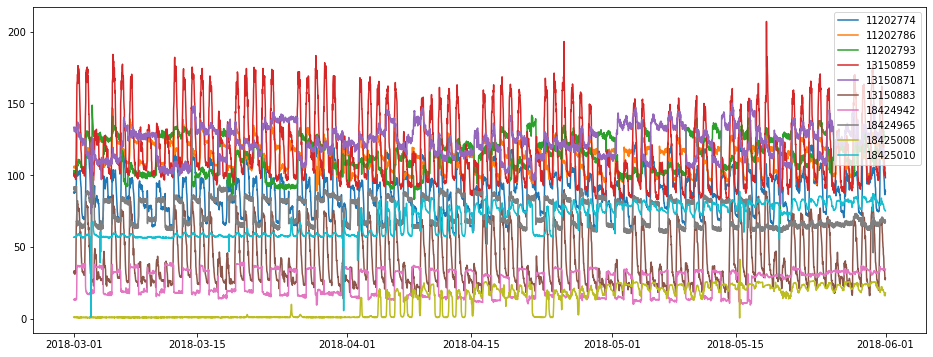

In [3]:
df = pd.read_csv('cpt_power_data.csv', sep='\t', encoding='utf-8', index_col=0)
df['timestamp_value'] = pd.to_datetime(df['timestamp_value'])
df.head()

for col in df:
    print(f'{col}:', len(df[col].unique()), '| sample:', df[col].unique()[:3])

plt.figure(figsize=(16, 6))
for ch_serial in df['measuringpoint_serial'].unique():
    plt.plot(df[df['measuringpoint_serial'] == ch_serial].timestamp_value, 
             df[df['measuringpoint_serial'] == ch_serial].value_text, 
             label=ch_serial)
plt.legend()
plt.show()    

### В эксперименте используем один ряд (ch_serial = df['measuringpoint_serial'].unique()[номер_ряда])

In [4]:
ch_serial = df['measuringpoint_serial'].unique()[0]
channel = pd.DataFrame(
    data=list(df[df['measuringpoint_serial'] == ch_serial].value_text),
    index=list(df[df['measuringpoint_serial'] == ch_serial].timestamp_value)
)
channel.columns = ['pwr']
print(channel.shape)
channel.head()

(4416, 1)


,pwr
2018-03-01 00:00:00,87.8
2018-03-01 00:30:00,87.4
2018-03-01 01:00:00,88.4
2018-03-01 01:30:00,88.8
2018-03-01 02:00:00,88.0


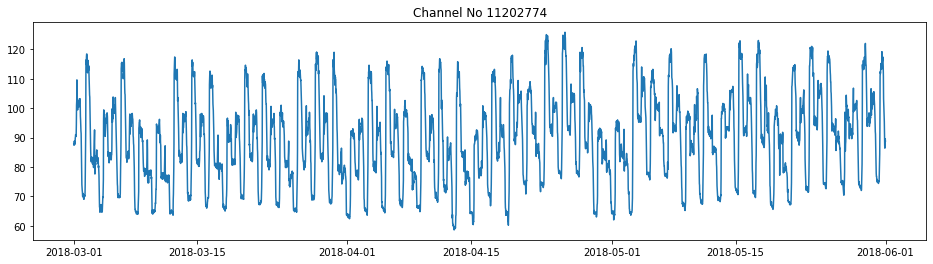

In [5]:
plt.figure(figsize=(16, 4))
plt.plot(channel)
plt.title(f'Channel No {ch_serial}')
plt.show()

### Доп признаки (как и в первоисточнике)

In [6]:
channel['n_day'] = channel.index.day.astype(np.int8)
channel['n_week'] = channel.index.week.astype(np.int8)
channel['n_month'] = channel.index.month.astype(np.int8)
channel['w_day'] = channel.index.weekday.astype(np.int8)
channel['is_weekend'] = (channel['w_day'] >= 5).astype(np.int8)
channel.head()

<ipython-input-6-b418614f4fa6>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  channel['n_week'] = channel.index.week.astype(np.int8)


,pwr,n_day,n_week,n_month,w_day,is_weekend
2018-03-01 00:00:00,87.8,1,9,3,3,0
2018-03-01 00:30:00,87.4,1,9,3,3,0
2018-03-01 01:00:00,88.4,1,9,3,3,0
2018-03-01 01:30:00,88.8,1,9,3,3,0
2018-03-01 02:00:00,88.0,1,9,3,3,0


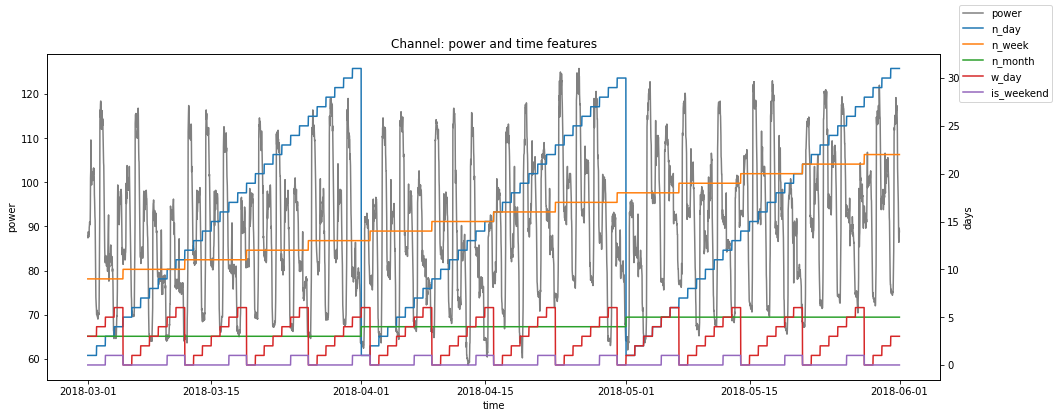

In [7]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.set_xlabel('time')
ax1.set_ylabel('power')
ax1.plot(channel.index, channel.pwr, label='power', color='grey')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('days')
for col in [x for x in channel.columns if '_' in x]:
    ax2.plot(channel.index, channel[col], label=col)
ax2.tick_params(axis='y')

fig.legend()
plt.title('Channel: power and time features')
plt.show()

### Подготовка данных

In [8]:
scaler, scaler_pwr = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))
scaler_pwr.fit(channel['pwr'].values.reshape(-1, 1))
with open(f'{MODEL_PATH}/scaler_pwr.pkl', 'wb') as file:
    pickle.dump(scaler_pwr, file)
channel = scaler.fit_transform(channel)
print('total elements:', len(channel))
print('one element of channel:', channel[0])

total elements: 4416
one element of channel: [0.43452381 0.         0.         0.         0.5        0.        ]


In [10]:
def get_dataset(series, col_look, look_back, look_fwd, cols_features):
    X, y = [], []
    for i in range(len(series[:, col_look]) - look_back - look_fwd):
        temp_X = []
        temp_X.append(series[:, col_look][i:(i + look_back)])
        for col in cols_features:
            temp_X.append(series[:, col][(i + look_fwd):(i + look_back + look_fwd)])
        X.append(temp_X)
        y.append(series[:, col_look][(i + look_back):(i + look_back + look_fwd)])
    return np.array(X), np.array(y)

In [11]:
look_fwd = 7 * 24 * 2 # days * hours * half an hour
print('look forward:', look_fwd)
look_back = 1 * look_fwd 
print('look back:', look_back)
X, y = get_dataset(channel, 0, look_back, look_fwd, [1, 2, 3, 4, 5])
print('X shape:', X.shape, '| y shape:', y.shape)
print('train sample:', X[0][:, 0])

look forward: 336
look back: 336
X shape: (3744, 6, 336) | y shape: (3744, 336)
train sample: [0.43452381 0.23333333 0.07692308 0.         0.5        0.        ]


In [12]:
def get_train_test(X, y, test_size=.25):
    cut = int((1 - test_size) * len(y))
    X_train, y_train = X[:cut], y[:cut]
    X_test, y_test = X[cut:], y[cut:]
    
    # LSTM feed [samples, time steps, features]
    print('as is:')
    print('\tX train shape:', X_train.shape, '| X test shape:', X_test.shape)
    print('\ty train shape:', y_train.shape, '| y test shape:', y_test.shape)
    print('\nreshaped to LSTM pattern [samples, time steps, features]:')
    X_train = np.array([x.T for x in X_train])
    X_test = np.array([x.T for x in X_test])
    print('\tX train shape:', X_train.shape, '| X test shape:', X_test.shape)
    print('\ty train shape:', y_train.shape, '| y test shape:', y_test.shape)
    
    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = get_train_test(X, y, test_size=.25)

as is:
	X train shape: (2808, 6, 336) | X test shape: (936, 6, 336)
	y train shape: (2808, 336) | y test shape: (936, 336)

reshaped to LSTM pattern [samples, time steps, features]:
	X train shape: (2808, 336, 6) | X test shape: (936, 336, 6)
	y train shape: (2808, 336) | y test shape: (936, 336)


### Обучение. параметры берем из оптимальных в первоисточнике. проверяем только влияние архитектуры сети

In [14]:
def get_model(units, n_features, 
              dropout, r_dropout,
              look_back, look_fwd,
              mtype=0, loss='mse'):
    model = Sequential()

    if mtype==5:
        model.add(LSTM(units=units, 
                       input_shape=(7 * 24 * 2, 6), 
                       return_sequences=True,                        
                       dropout=0.42, 
                       recurrent_dropout=r_dropout))
        model.add(GRU(units=units, 
                       dropout=0.42, 
                       recurrent_dropout=r_dropout))
        model.add(Dense(7 * 24 * 2))
        model.add(Dense(7 * 24 * 2 * 2))
        model.add(Dense(7 * 24 * 2 * 2))
        model.add(Dense(7 * 24 * 2))        

    elif mtype==4:
        model.add(GRU(units=units, 
                       input_shape=(look_back, n_features), 
                       return_sequences=True,                        
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
        model.add(GRU(units=units, 
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
        model.add(Dense(look_fwd))
        model.add(Dense(units*2))
        model.add(Dense(look_fwd))
        model.add(Dense(look_fwd))        
    elif mtype==3:
        model.add(LSTM(units=units, 
                       input_shape=(look_back, n_features), 
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
        model.add(Dense(look_fwd))
        model.add(Dense(look_fwd*2))
    elif mtype==2:
        model.add(GRU(units=units, 
                       input_shape=(look_back, n_features), 
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
        model.add(Dense(look_fwd))
        model.add(Dense(look_fwd*2))
    elif mtype==1:
        model.add(GRU(units=units, 
                       input_shape=(look_back, n_features), 
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))
    elif mtype==0:
        model.add(LSTM(units=units, 
                       input_shape=(look_back, n_features),
                       dropout=dropout, 
                       recurrent_dropout=r_dropout))

    model.add(Dense(look_fwd))
    model.add(Activation('linear'))
    
    adam = optimizers.Adam(lr=.001, clipvalue=.5, clipnorm=1)
    model.compile(loss=loss, optimizer=adam)
    return model

In [15]:
def train_model(_mtype,_epochs):

    model = get_model(
        units=128, 
        n_features=6, 
        dropout=.4,
        r_dropout=0,
        look_back=look_back, 
        look_fwd=look_fwd,
        mtype=_mtype, 
        loss='mse'
    )
    model.summary()
    
    tf.debugging.set_log_device_placement(True)
    checkpoint_path = f'{MODEL_PATH}/model.hdf5'
    earlystopper = EarlyStopping(
        monitor='val_loss', 
        patience=20, 
        verbose=1,
        mode='min'
    )
    lrreducer = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=.1, 
        patience=10, 
        verbose=1, 
        min_lr=1e-6,
        mode='min'
    )
    checkpointer = ModelCheckpoint(
        checkpoint_path, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True,
        save_weights_only=True, 
        mode='min'
    )
    callbacks = [earlystopper, checkpointer, lrreducer]

    history = model.fit(
        X_train, y_train, 
        epochs=_epochs, 
        batch_size=32, 
        validation_data=(X_test, y_test), 
        verbose=1,
        callbacks=callbacks,
        shuffle=False
    )
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    plt.figure(figsize=(16, 4))
    y_pred = model.predict(X_test[0:1])[0]
    plt.plot(y_test[0], label='true')
    plt.plot(y_pred, label='predict')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_test[0:1])[0]

    with open(f'{MODEL_PATH}/scaler_pwr.pkl', 'rb') as f:
        scaler_pwr = pickle.load(f)

    plt.figure(figsize=(16, 4))
    past = range(len(X_train[0][:, 0]))
    future = range(len(X_train[0][:, 0]), len(X_train[0][:, 0]) + len(y_test[0]))
    plt.plot(past, 
             scaler_pwr.inverse_transform(X_train[-1][:, 0].reshape(-1, 1)), 
             label='train')
    plt.plot(future, 
             scaler_pwr.inverse_transform(y_test[0].reshape(-1, 1)), 
             label='true')
    plt.plot(future, 
             scaler_pwr.inverse_transform(y_pred.reshape(-1, 1)), 
             label='predict')
    plt.legend()
    plt.show()    
    channel_ = pd.DataFrame(
        data=list(df[df['measuringpoint_serial'] == ch_serial].value_text),
        index=list(df[df['measuringpoint_serial'] == ch_serial].timestamp_value)
    )
    plt.figure(figsize=(16, 4))
    start_point = len(X_train) + look_back
    plt.plot(channel_[(start_point - 2 * look_back):(start_point + len(y_pred))], 
             label='true')
    plt.plot(channel_.index[start_point:(start_point + len(y_pred))],
             scaler_pwr.inverse_transform(y_pred.reshape(-1, 1)), 
             label='predict')
    plt.legend()
    plt.show()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               69120     
_________________________________________________________________
dense (Dense)                (None, 336)               43344     
_________________________________________________________________
activation (Activation)      (None, 336)               0         
Total params: 112,464
Trainable params: 112,464
Non-trainable params: 0
_________________________________________________________________
Epoch 1/156
33/33 [==============================] - ETA: 0s - loss: 0.0972
Epoch 00001: val_loss improved from inf to 0.05234, saving model to ./models\model.hdf5
33/33 [==============================] - 3s 95ms/step - loss: 0.0972 - val_loss: 0.0523
Epoch 2/156
33/33 [==============================] - ETA: 0s - loss: 0.0559
Epoch 00002: val_loss improved from 0.05234 to 0.049

Epoch 32/156
33/33 [==============================] - ETA: 0s - loss: 0.0228
Epoch 00032: val_loss did not improve from 0.01491
33/33 [==============================] - 3s 81ms/step - loss: 0.0228 - val_loss: 0.0233
Epoch 33/156
33/33 [==============================] - ETA: 0s - loss: 0.0232
Epoch 00033: val_loss did not improve from 0.01491
33/33 [==============================] - 3s 79ms/step - loss: 0.0232 - val_loss: 0.0237
Epoch 34/156
33/33 [==============================] - ETA: 0s - loss: 0.0239
Epoch 00034: val_loss improved from 0.01491 to 0.01413, saving model to ./models\model.hdf5
33/33 [==============================] - 3s 80ms/step - loss: 0.0239 - val_loss: 0.0141
Epoch 35/156
33/33 [==============================] - ETA: 0s - loss: 0.0207
Epoch 00035: val_loss did not improve from 0.01413
33/33 [==============================] - 3s 78ms/step - loss: 0.0207 - val_loss: 0.0190
Epoch 36/156
33/33 [==============================] - ETA: 0s - loss: 0.0313
Epoch 00036: val_l

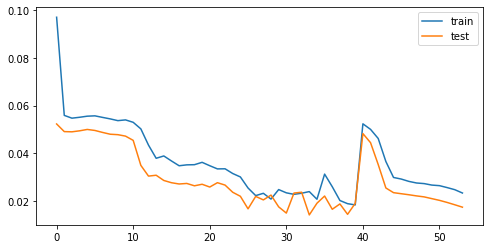

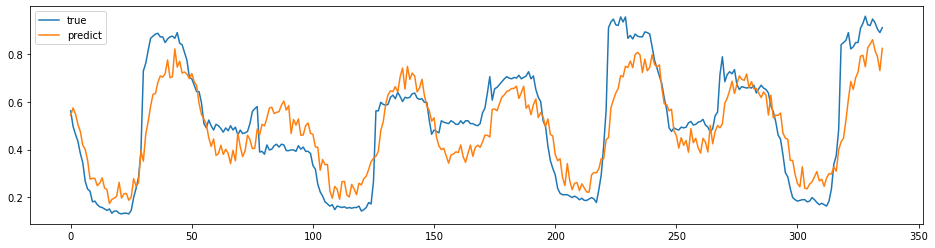

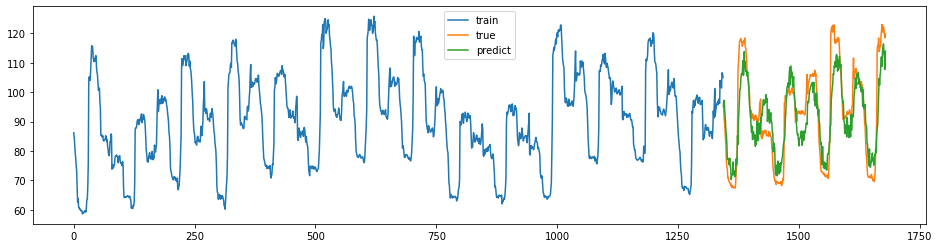

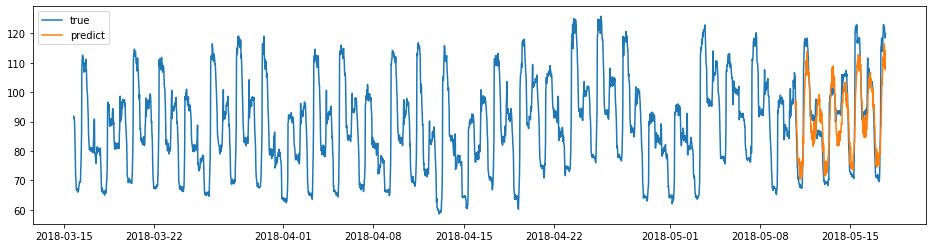

Wall time: 2min 34s


In [15]:
%%time
train_model(0,156)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               52224     
_________________________________________________________________
dense_1 (Dense)              (None, 336)               43344     
_________________________________________________________________
activation_1 (Activation)    (None, 336)               0         
Total params: 95,568
Trainable params: 95,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/156
32/33 [============================>.] - ETA: 0s - loss: 0.1115
Epoch 00001: val_loss improved from inf to 0.05496, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 63ms/step - loss: 0.1114 - val_loss: 0.0550
Epoch 2/156
33/33 [==============================] - ETA: 0s - loss: 0.0589
Epoch 00002: val_loss improved from 0.05496 to 0.049

33/33 [==============================] - ETA: 0s - loss: 0.0237
Epoch 00032: val_loss did not improve from 0.01894
33/33 [==============================] - 2s 50ms/step - loss: 0.0237 - val_loss: 0.0198
Epoch 33/156
33/33 [==============================] - ETA: 0s - loss: 0.0241
Epoch 00033: val_loss improved from 0.01894 to 0.01871, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 50ms/step - loss: 0.0241 - val_loss: 0.0187
Epoch 34/156
33/33 [==============================] - ETA: 0s - loss: 0.0218
Epoch 00034: val_loss did not improve from 0.01871
33/33 [==============================] - 2s 49ms/step - loss: 0.0218 - val_loss: 0.0195
Epoch 35/156
33/33 [==============================] - ETA: 0s - loss: 0.0206
Epoch 00035: val_loss improved from 0.01871 to 0.01750, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 51ms/step - loss: 0.0206 - val_loss: 0.0175
Epoch 36/156
32/33 [============================>.] - ETA: 0s - los

Epoch 68/156
33/33 [==============================] - ETA: 0s - loss: 0.0126
Epoch 00068: val_loss did not improve from 0.01468
33/33 [==============================] - 2s 50ms/step - loss: 0.0126 - val_loss: 0.0147
Epoch 69/156
33/33 [==============================] - ETA: 0s - loss: 0.0125
Epoch 00069: val_loss improved from 0.01468 to 0.01464, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 51ms/step - loss: 0.0125 - val_loss: 0.0146
Epoch 70/156
33/33 [==============================] - ETA: 0s - loss: 0.0126
Epoch 00070: val_loss did not improve from 0.01464
33/33 [==============================] - 2s 52ms/step - loss: 0.0126 - val_loss: 0.0147
Epoch 71/156
33/33 [==============================] - ETA: 0s - loss: 0.0125
Epoch 00071: val_loss improved from 0.01464 to 0.01463, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 50ms/step - loss: 0.0125 - val_loss: 0.0146
Epoch 72/156
33/33 [==============================] - 

Epoch 103/156
33/33 [==============================] - ETA: 0s - loss: 0.0115
Epoch 00103: val_loss improved from 0.01389 to 0.01389, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 50ms/step - loss: 0.0115 - val_loss: 0.0139
Epoch 104/156
33/33 [==============================] - ETA: 0s - loss: 0.0115
Epoch 00104: val_loss improved from 0.01389 to 0.01385, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 50ms/step - loss: 0.0115 - val_loss: 0.0138
Epoch 105/156
32/33 [============================>.] - ETA: 0s - loss: 0.0114
Epoch 00105: val_loss did not improve from 0.01385

Epoch 00105: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
33/33 [==============================] - 2s 51ms/step - loss: 0.0114 - val_loss: 0.0139
Epoch 106/156
33/33 [==============================] - ETA: 0s - loss: 0.0114- ETA: 0s - loss:
Epoch 00106: val_loss did not improve from 0.01385
33/33 [==============================] 

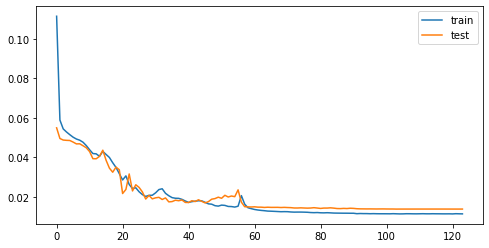

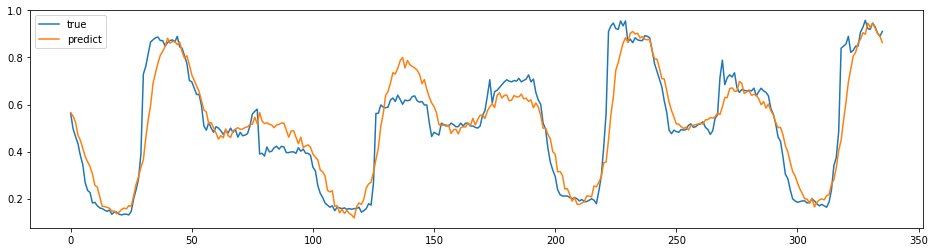

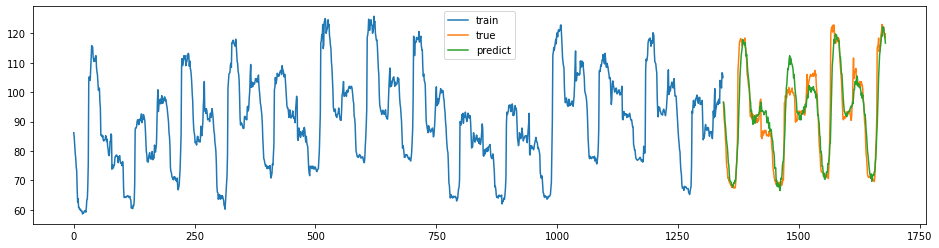

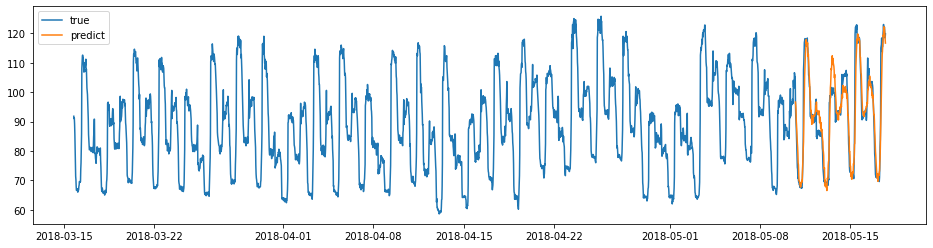

Wall time: 3min 39s


In [16]:
%%time
train_model(1,156)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               52224     
_________________________________________________________________
dense_2 (Dense)              (None, 336)               43344     
_________________________________________________________________
dense_3 (Dense)              (None, 672)               226464    
_________________________________________________________________
dense_4 (Dense)              (None, 336)               226128    
_________________________________________________________________
activation_2 (Activation)    (None, 336)               0         
Total params: 548,160
Trainable params: 548,160
Non-trainable params: 0
_________________________________________________________________
Epoch 1/156
32/33 [============================>.] - ETA: 0s - loss: 0.1021
Epoch 00001: val_loss improved from in

Epoch 31/156
33/33 [==============================] - ETA: 0s - loss: 0.0258
Epoch 00031: val_loss did not improve from 0.02077
33/33 [==============================] - 2s 51ms/step - loss: 0.0258 - val_loss: 0.0223
Epoch 32/156
33/33 [==============================] - ETA: 0s - loss: 0.0256
Epoch 00032: val_loss improved from 0.02077 to 0.01897, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 51ms/step - loss: 0.0256 - val_loss: 0.0190
Epoch 33/156
33/33 [==============================] - ETA: 0s - loss: 0.0226
Epoch 00033: val_loss improved from 0.01897 to 0.01801, saving model to ./models\model.hdf5
33/33 [==============================] - 2s 51ms/step - loss: 0.0226 - val_loss: 0.0180
Epoch 34/156
32/33 [============================>.] - ETA: 0s - loss: 0.0237- ETA: 0s - loss: 0
Epoch 00034: val_loss did not improve from 0.01801
33/33 [==============================] - 2s 49ms/step - loss: 0.0237 - val_loss: 0.0201
Epoch 35/156
33/33 [===============

33/33 [==============================] - ETA: 0s - loss: 0.0153
Epoch 00067: val_loss did not improve from 0.01798
33/33 [==============================] - 2s 51ms/step - loss: 0.0153 - val_loss: 0.0194
Epoch 68/156
33/33 [==============================] - ETA: 0s - loss: 0.0155
Epoch 00068: val_loss did not improve from 0.01798
33/33 [==============================] - 2s 50ms/step - loss: 0.0155 - val_loss: 0.0194
Epoch 69/156
33/33 [==============================] - ETA: 0s - loss: 0.0154
Epoch 00069: val_loss did not improve from 0.01798
33/33 [==============================] - 2s 50ms/step - loss: 0.0154 - val_loss: 0.0194
Epoch 70/156
33/33 [==============================] - ETA: 0s - loss: 0.0155
Epoch 00070: val_loss did not improve from 0.01798
33/33 [==============================] - 2s 50ms/step - loss: 0.0155 - val_loss: 0.0194
Epoch 71/156
32/33 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 00071: val_loss did not improve from 0.01798
33/33 [==============

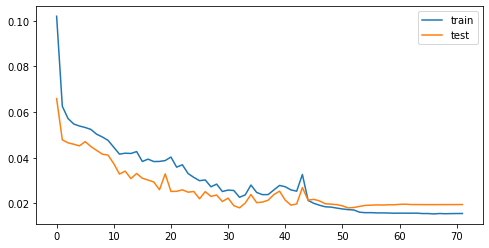

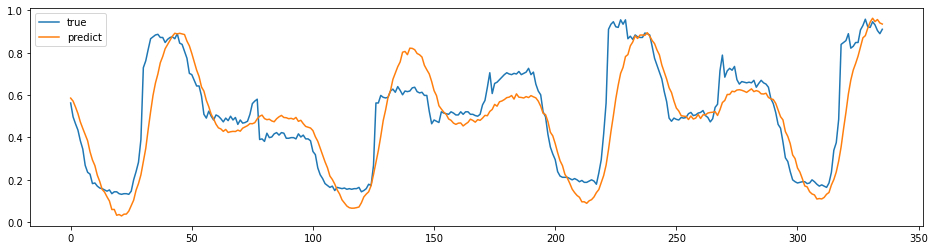

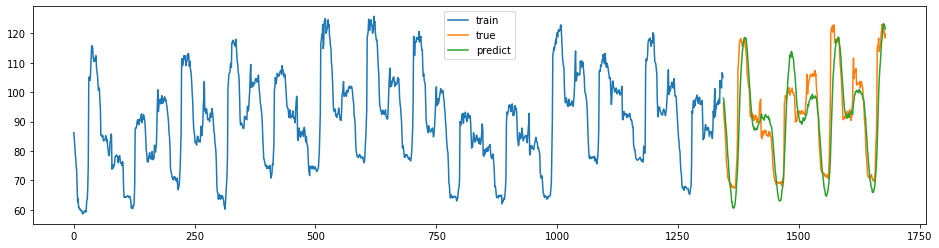

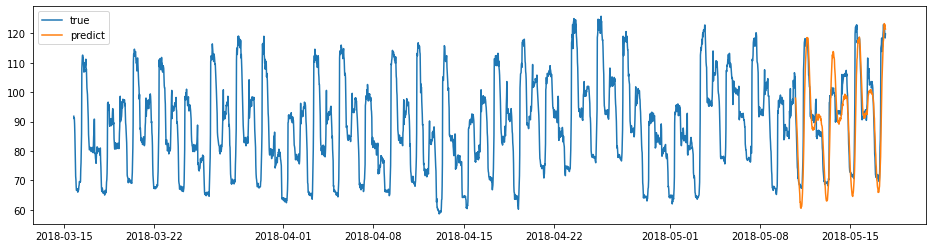

Wall time: 2min 8s


In [17]:
%%time
train_model(2,156)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               69120     
_________________________________________________________________
dense_5 (Dense)              (None, 336)               43344     
_________________________________________________________________
dense_6 (Dense)              (None, 672)               226464    
_________________________________________________________________
dense_7 (Dense)              (None, 336)               226128    
_________________________________________________________________
activation_3 (Activation)    (None, 336)               0         
Total params: 565,056
Trainable params: 565,056
Non-trainable params: 0
_________________________________________________________________
Epoch 1/156
33/33 [==============================] - ETA: 0s - loss: 0.0981
Epoch 00001: val_loss improved from in

Epoch 32/156
33/33 [==============================] - ETA: 0s - loss: 0.0236
Epoch 00032: val_loss did not improve from 0.01622
33/33 [==============================] - 3s 80ms/step - loss: 0.0236 - val_loss: 0.0207
Epoch 33/156
33/33 [==============================] - ETA: 0s - loss: 0.0251
Epoch 00033: val_loss did not improve from 0.01622
33/33 [==============================] - 3s 78ms/step - loss: 0.0251 - val_loss: 0.0211
Epoch 34/156
33/33 [==============================] - ETA: 0s - loss: 0.0257
Epoch 00034: val_loss did not improve from 0.01622
33/33 [==============================] - 3s 80ms/step - loss: 0.0257 - val_loss: 0.0221
Epoch 35/156
33/33 [==============================] - ETA: 0s - loss: 0.0265
Epoch 00035: val_loss did not improve from 0.01622
33/33 [==============================] - 3s 78ms/step - loss: 0.0265 - val_loss: 0.0170
Epoch 36/156
33/33 [==============================] - ETA: 0s - loss: 0.0255
Epoch 00036: val_loss did not improve from 0.01622
33/33 [=

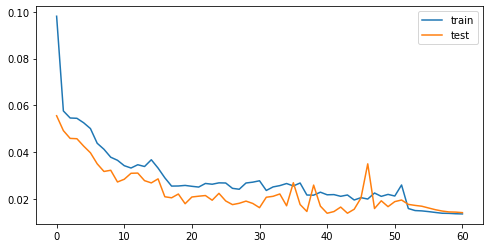

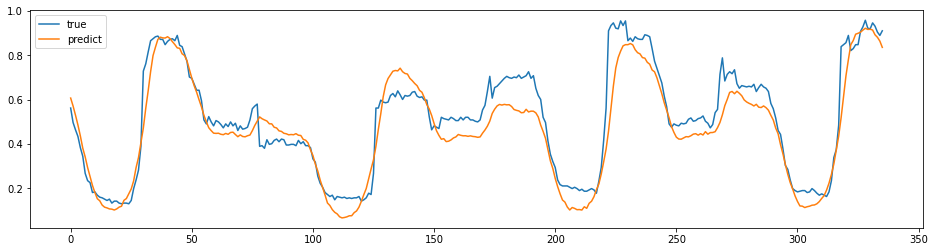

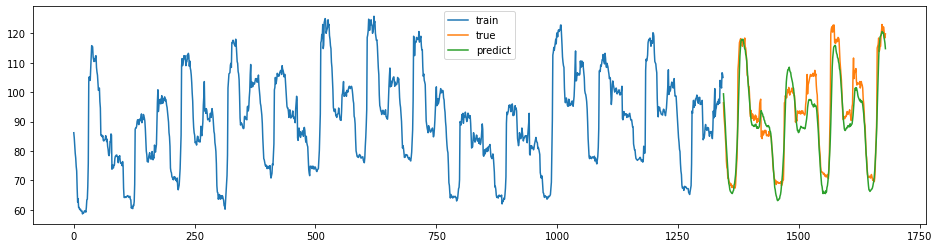

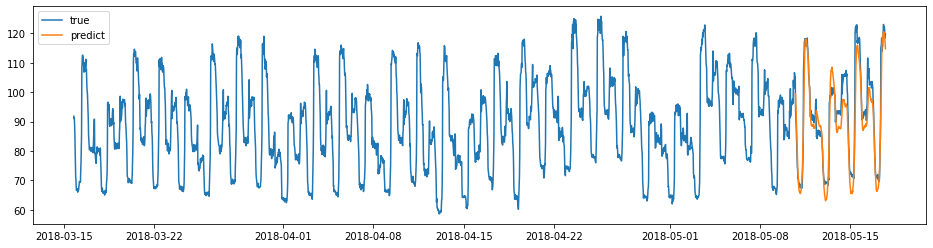

Wall time: 2min 49s


In [18]:
%%time
train_model(3,156)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2688, 128)         52224     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 336)               43344     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               86272     
_________________________________________________________________
dense_2 (Dense)              (None, 336)               86352     
_________________________________________________________________
dense_3 (Dense)              (None, 336)               113232    
_________________________________________________________________
dense_4 (Dense)              (None, 336)               1

Epoch 29/156
33/33 [==============================] - ETA: 0s - loss: 0.0399
Epoch 00029: val_loss improved from 0.03437 to 0.03423, saving model to ./models\model.hdf5
33/33 [==============================] - 6s 178ms/step - loss: 0.0399 - val_loss: 0.0342
Epoch 30/156
33/33 [==============================] - ETA: 0s - loss: 0.0396
Epoch 00030: val_loss improved from 0.03423 to 0.03407, saving model to ./models\model.hdf5
33/33 [==============================] - 6s 179ms/step - loss: 0.0396 - val_loss: 0.0341
Epoch 31/156
33/33 [==============================] - ETA: 0s - loss: 0.0395
Epoch 00031: val_loss improved from 0.03407 to 0.03380, saving model to ./models\model.hdf5
33/33 [==============================] - 6s 174ms/step - loss: 0.0395 - val_loss: 0.0338
Epoch 32/156
33/33 [==============================] - ETA: 0s - loss: 0.0395
Epoch 00032: val_loss improved from 0.03380 to 0.03352, saving model to ./models\model.hdf5
33/33 [==============================] - 6s 175ms/step - 

Epoch 63/156
33/33 [==============================] - ETA: 0s - loss: 0.0233
Epoch 00063: val_loss improved from 0.01645 to 0.01640, saving model to ./models\model.hdf5
33/33 [==============================] - 6s 175ms/step - loss: 0.0233 - val_loss: 0.0164
Epoch 64/156
33/33 [==============================] - ETA: 0s - loss: 0.0237
Epoch 00064: val_loss improved from 0.01640 to 0.01635, saving model to ./models\model.hdf5
33/33 [==============================] - 6s 176ms/step - loss: 0.0237 - val_loss: 0.0163
Epoch 65/156
33/33 [==============================] - ETA: 0s - loss: 0.0245
Epoch 00065: val_loss did not improve from 0.01635
33/33 [==============================] - 6s 176ms/step - loss: 0.0245 - val_loss: 0.0195
Epoch 66/156
33/33 [==============================] - ETA: 0s - loss: 0.0228
Epoch 00066: val_loss improved from 0.01635 to 0.01574, saving model to ./models\model.hdf5
33/33 [==============================] - 6s 177ms/step - loss: 0.0228 - val_loss: 0.0157
Epoch 67/

33/33 [==============================] - ETA: 0s - loss: 0.0191
Epoch 00099: val_loss did not improve from 0.01462
33/33 [==============================] - 6s 175ms/step - loss: 0.0191 - val_loss: 0.0173
Epoch 100/156
33/33 [==============================] - ETA: 0s - loss: 0.0192
Epoch 00100: val_loss did not improve from 0.01462
33/33 [==============================] - 6s 175ms/step - loss: 0.0192 - val_loss: 0.0172
Epoch 101/156
33/33 [==============================] - ETA: 0s - loss: 0.0190
Epoch 00101: val_loss did not improve from 0.01462
33/33 [==============================] - 6s 175ms/step - loss: 0.0190 - val_loss: 0.0164
Epoch 102/156
33/33 [==============================] - ETA: 0s - loss: 0.0189
Epoch 00102: val_loss did not improve from 0.01462
33/33 [==============================] - 6s 175ms/step - loss: 0.0189 - val_loss: 0.0164
Epoch 103/156
33/33 [==============================] - ETA: 0s - loss: 0.0187
Epoch 00103: val_loss did not improve from 0.01462
33/33 [======

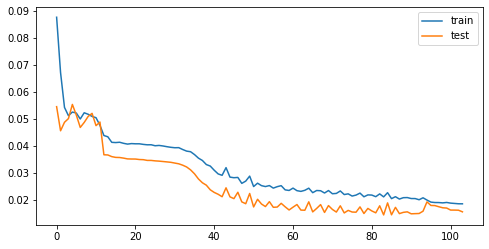

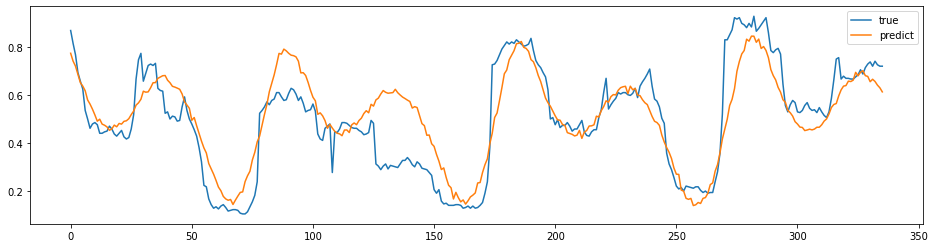

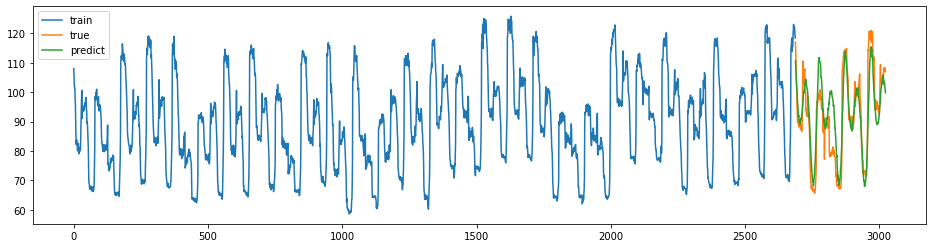

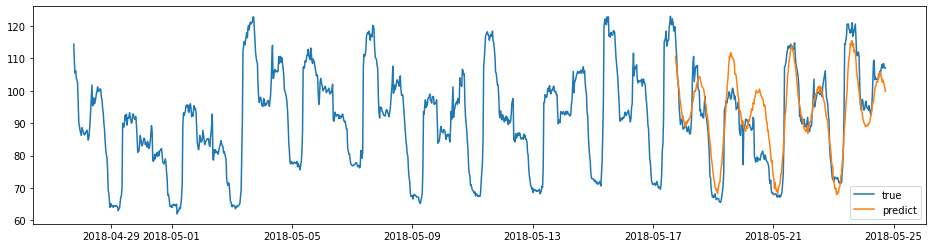

Wall time: 10min 28s


In [17]:
%%time
train_model(4,156)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 336, 128)          69120     
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 336)               43344     
_________________________________________________________________
dense_1 (Dense)              (None, 672)               226464    
_________________________________________________________________
dense_2 (Dense)              (None, 672)               452256    
_________________________________________________________________
dense_3 (Dense)              (None, 336)               226128    
_________________________________________________________________
dense_4 (Dense)              (None, 336)               1

Epoch 30/156
87/88 [============================>.] - ETA: 0s - loss: 0.0218
Epoch 00030: val_loss did not improve from 0.01974
88/88 [==============================] - 3s 34ms/step - loss: 0.0218 - val_loss: 0.0220
Epoch 31/156
87/88 [============================>.] - ETA: 0s - loss: 0.0209
Epoch 00031: val_loss did not improve from 0.01974
88/88 [==============================] - 3s 34ms/step - loss: 0.0209 - val_loss: 0.0241
Epoch 32/156
87/88 [============================>.] - ETA: 0s - loss: 0.0198
Epoch 00032: val_loss did not improve from 0.01974
88/88 [==============================] - 3s 34ms/step - loss: 0.0198 - val_loss: 0.0220
Epoch 33/156
87/88 [============================>.] - ETA: 0s - loss: 0.0208
Epoch 00033: val_loss improved from 0.01974 to 0.01882, saving model to ./models\model.hdf5
88/88 [==============================] - 3s 37ms/step - loss: 0.0208 - val_loss: 0.0188
Epoch 34/156
87/88 [============================>.] - ETA: 0s - loss: 0.0195
Epoch 00034: val_l

87/88 [============================>.] - ETA: 0s - loss: 0.0140
Epoch 00064: val_loss improved from 0.01311 to 0.01309, saving model to ./models\model.hdf5
88/88 [==============================] - 3s 34ms/step - loss: 0.0140 - val_loss: 0.0131
Epoch 65/156
87/88 [============================>.] - ETA: 0s - loss: 0.0139
Epoch 00065: val_loss did not improve from 0.01309
88/88 [==============================] - 3s 34ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 66/156
87/88 [============================>.] - ETA: 0s - loss: 0.0137
Epoch 00066: val_loss did not improve from 0.01309
88/88 [==============================] - 3s 34ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 67/156
87/88 [============================>.] - ETA: 0s - loss: 0.0138
Epoch 00067: val_loss did not improve from 0.01309
88/88 [==============================] - 3s 34ms/step - loss: 0.0138 - val_loss: 0.0133
Epoch 68/156
87/88 [============================>.] - ETA: 0s - loss: 0.0136- ETA: 0s - loss:
Epoch 00068: v

Epoch 99/156
87/88 [============================>.] - ETA: 0s - loss: 0.0110
Epoch 00099: val_loss did not improve from 0.01124

Epoch 00099: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
88/88 [==============================] - 3s 34ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 100/156
87/88 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 00100: val_loss did not improve from 0.01124
88/88 [==============================] - 3s 34ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 101/156
87/88 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 00101: val_loss did not improve from 0.01124
88/88 [==============================] - 3s 34ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 102/156
87/88 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 00102: val_loss did not improve from 0.01124
88/88 [==============================] - 3s 34ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 103/156
87/88 [============================>.

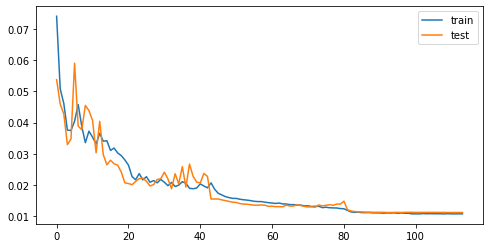

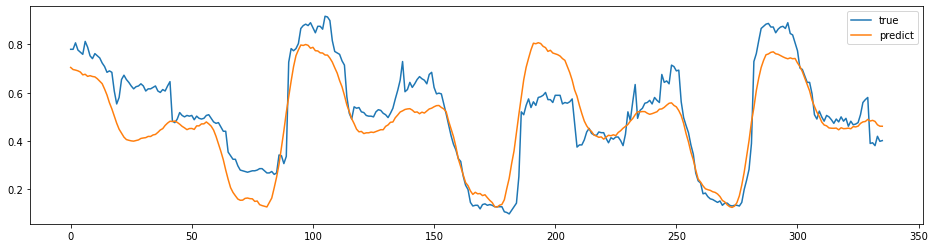

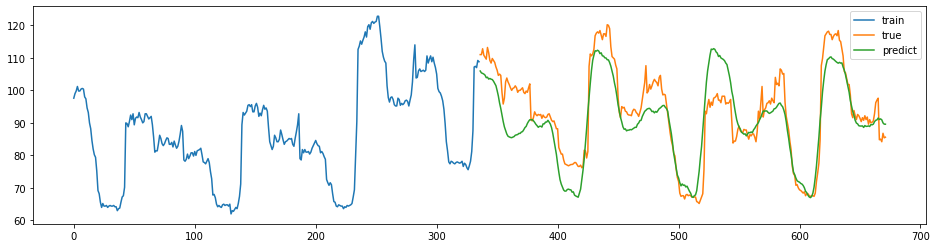

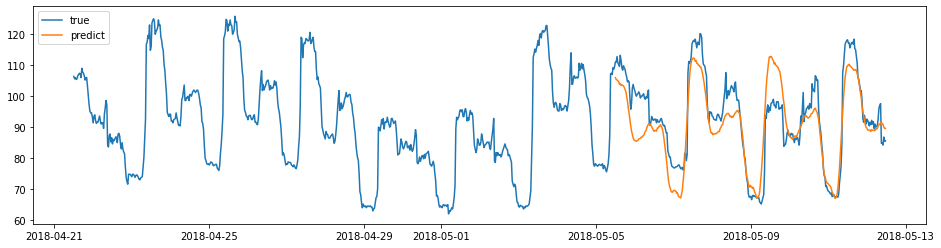

Wall time: 5min 59s


In [16]:
%%time
train_model(5,156)